Import necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Load the Mobile Games dataset

In [5]:
df = pd.read_csv("C:/Users/panig/Downloads/cookie_cats.csv/cookie_cats.csv")

Explore the dataset

In [6]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [7]:
df.describe()

,userid,sum_gamerounds
count,90189.0000,90189.0000
mean,4998412.2345,51.8725
std,2883285.6077,195.0509
min,116.0000,0.0000
25%,2512230.0000,5.0000
50%,4995815.0000,16.0000
75%,7496452.0000,51.0000
max,9999861.0000,49854.0000


In [8]:
print(df.describe(include='all'))

             userid  version  sum_gamerounds retention_1 retention_7
count    90189.0000    90189      90189.0000       90189       90189
unique          NaN        2             NaN           2           2
top             NaN  gate_40             NaN       False       False
freq            NaN    45489             NaN       50036       73408
mean   4998412.2345      NaN         51.8725         NaN         NaN
std    2883285.6077      NaN        195.0509         NaN         NaN
min        116.0000      NaN          0.0000         NaN         NaN
25%    2512230.0000      NaN          5.0000         NaN         NaN
50%    4995815.0000      NaN         16.0000         NaN         NaN
75%    7496452.0000      NaN         51.0000         NaN         NaN
max    9999861.0000      NaN      49854.0000         NaN         NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [10]:
#I write a function to summarize the general information about the dataset.
def check_df(dataframe, head=10):
    print('\033[1m' + 10*"*" + ' SHAPE ' + 10*"*" + '\033[0m')
    print(f"Rows:{dataframe.shape[0]}")
    print(f"Columns:{dataframe.shape[1]}")

    print('\033[1m' + 10*"*" + ' TYPES ' + 10*"*" + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + 10*"*" + ' HEAD ' + 10*"*" + '\033[0m')
    print(dataframe.head(head))

    print('\033[1m' + 10*"*" + ' TAIL ' + 10*"*" + '\033[0m')
    print(dataframe.tail(head))

    print('\033[1m' + 10*"*" + ' COLUMNS ' + 10*"*" + '\033[0m')
    print(dataframe.columns)

    print('\033[1m' + 10*"*" + ' NUNIQUE ELEMENTS ' + 10*"*" + '\033[0m')
    print(dataframe.nunique())
    print('\033[1m' + 10*"*" + ' NA ' + 10*"*" + '\033[0m')
    print(dataframe.isnull().sum())

    print('\033[1m' + 10*"*" + ' DESCRIBE ' + 10*"*" + '\033[0m')
    print(dataframe.describe().T)
    
check_df(df,10)

********** SHAPE **********
Rows:90189
Columns:5
********** TYPES **********
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
********** HEAD **********
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
********** TAIL **********
        userid  version  sum_gamerounds  retention_1  reten

<Axes: xlabel='version', ylabel='count'>

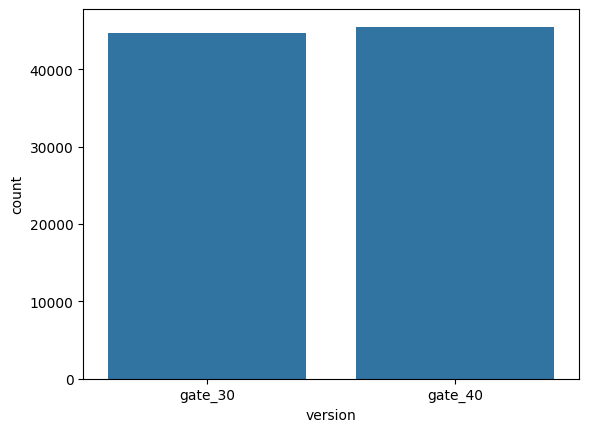

In [11]:
df.groupby("version")["userid"].count()
sns.countplot(x="version",data=df)

In [12]:
df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}).reset_index()

version sum_gamerounds        
                    count    mean
0  gate_30          44700 52.4563
1  gate_40          45489 51.2988

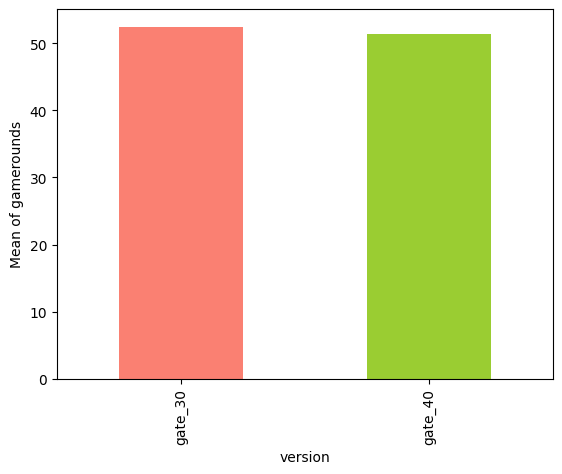

In [13]:
df.groupby("version")["sum_gamerounds"].mean()
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "salmon", "yellowgreen"]);

plt.ylabel("Mean of gamerounds");

Outliers

In [14]:
df.sum_gamerounds.describe()

count   90189.0000
mean       51.8725
std       195.0509
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max     49854.0000
Name: sum_gamerounds, dtype: float64

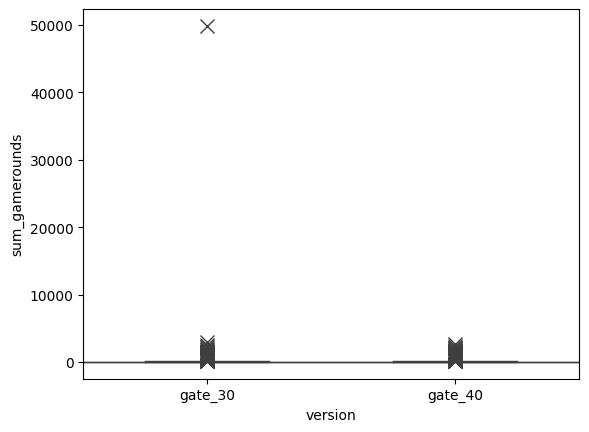

In [15]:
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=1.0, fliersize=10);

In [16]:
# I write a function to get rid of the outlier values.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [17]:
replace_with_thresholds(df, "sum_gamerounds")

In [18]:
df.sum_gamerounds.describe()

count   90189.0000
mean       51.1092
std        99.3123
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max      1232.5000
Name: sum_gamerounds, dtype: float64

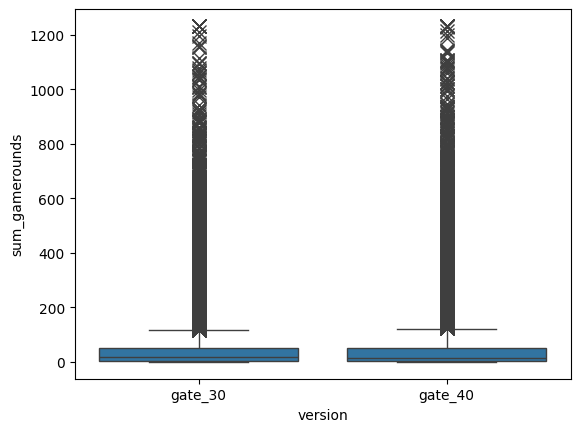

In [19]:
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=0.8, fliersize=10);

A/B Testing

In [20]:
def AB_Test(df, pthres=0.05):
    
    # H0:  There is no statistical difference between the gate_30 and the gate_40.
    
    print(df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}))

    print("NORMAL DISTRIBUTION ASSUMPTION" .center(70,"*"))
    
    # H0 : The compared groups have a normal distribution
    
    pvalue_gate_30 = shapiro([df["version"] == "gate_30"])[1]
    pvalue_gate_40 = shapiro([df["version"] == "gate_40"])[1]
    
    print('p-value_gate30 = %.5f' % (pvalue_gate_30))
    print('p-value_gate40 = %.5f' % (pvalue_gate_40))

    if (pvalue_gate_30 < pthres) & (pvalue_gate_40 < pthres):
        print("Normality H0 is rejected.\n\n")
    else:
        print("Normality H0 is not rejected.\n")

    print("VARIANCE HOMOGENEOUS ASSUMPTION ".center(70,"*"))
    
    # H0 : The variance of compared groups is homegenous.
    
    p_value_levene = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
    
    print('p_value_levene = %.5f' % p_value_levene)

    if p_value_levene < pthres:
        print("Variance Homogeneity H0 is rejected.\n")
    else:
        print("Variance Homogeneity H0 is not rejected.\n")

    if ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene > pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=True)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)

    elif ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene < pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=False)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)
    else:
        print("Non-Parametric test should be done.\n\n")
        pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                              df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
        
        print('p_value = %.5f' % pvalue)

    print(" RESULT ".center(70,"*"))

    if pvalue < pthres:
        print(
            f"p-value {round(pvalue, 5)} < 0.05  H0 Hypothesis is Rejected. That is, there is a statistically significant difference between them.")

    else:
        print(
            f"p-value > {pthres} H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.")
AB_Test(df,0.05)

        sum_gamerounds        
                 count    mean
version                       
gate_30          44700 51.1534
gate_40          45489 51.0658
********************NORMAL DISTRIBUTION ASSUMPTION********************
p-value_gate30 = 0.00000
p-value_gate40 = 0.00000
Normality H0 is rejected.


*******************VARIANCE HOMOGENEOUS ASSUMPTION *******************
p_value_levene = 0.83018
Variance Homogeneity H0 is not rejected.

Non-Parametric test should be done.


p_value = 0.05021
******************************* RESULT *******************************
p-value > 0.05 H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.
